In [36]:
# Cell [1]: Check Environment
import os
print(f"Current directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")
print(f"Data folder exists: {os.path.exists('data')}")

Current directory: C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package
Files in current directory: ['.git', '.gitignore', '.ipynb_checkpoints', '.pre-commit-config.yaml', '.pytest_cache', 'artifacts', 'configs', 'data', 'docs', 'mlruns', 'notebooks', 'pytest.ini', 'requirements.txt', 'run_api.py', 'setup.py', 'src', 'tests']
Data folder exists: True


In [37]:
# Cell [2]: Setup Path
import os
import sys

# If you're in notebooks/, change directory to parent
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"✓ Changed to: {os.getcwd()}")

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
print(f"✓ Added to path: {os.path.join(os.getcwd(), 'src')}")
print(f"✓ Data folder exists: {os.path.exists('data')}")

✓ Added to path: C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package\src
✓ Data folder exists: True


In [38]:
# Cell [3]: Import and Load Config
from ml_framework.training import Trainer
from ml_framework.utils import load_config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For API testing
import requests
import json
from datetime import datetime

# Load configuration
config = load_config('configs/config.yaml')

print("Configuration loaded successfully!")
print("="*60)
print(f"Experiment: {config.experiment.name}")
print(f"Model: {config.model.type}")
print(f"MLflow URI: {config.experiment.mlflow_tracking_uri}")
print(f"Test size: {config.data.test_size}")
print(f"Random seed: {config.reproducibility.seed}")

Configuration loaded successfully!
Experiment: customer_conversion_baseline
Model: logistic_regression
MLflow URI: mlruns
Test size: 0.2
Random seed: 42


In [39]:
# Cell [4]: Initialize and Train (WITH MLFLOW!)
print("Starting training with MLflow tracking...")
print("="*60)

# Initialize trainer
trainer = Trainer(config)

# Run training (this will log to MLflow automatically)
results = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\nMetrics:")
for metric, value in results['metrics'].items():
    if value is not None:
        print(f"  {metric}: {value:.4f}")

print(f"\nArtifacts saved to: {results['artifact_dir']}")
print("\nCheck console output above for 'MLflow Run ID'")

Starting training with MLflow tracking...
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - Experiment 'customer_conversion_baseline' initialized
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - Set random seed: 42
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - MLflow tracking URI: mlruns
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - MLflow experiment: customer_conversion_baseline
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - Artifact directory: artifacts\customer_conversion_baseline_20251111_132219
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - Trainer initialized for experiment: customer_conversion_baseline
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-11 13:22:19 - experiment.customer_conversion_baseline - INFO - Starting experiment: customer_conversio


customers validation WARNINGS:
  ⚠️  Found 4 customers (2.0%) with MRR ≤ 0 (pipeline will clean these)

noncustomers validation WARNINGS:
  ⚠️  Soft uniqueness check failed for key ('id',): 3 duplicates found (acceptable but flagged)

⚠️  DUPLICATES FOUND: noncustomers
Found 6 duplicate rows for key=['id']
Unique IDs affected: 3
Strategy 'most_complete' will be applied.


Sample duplicate groups:
      id  _duplicate_group
446  278                 0
447  278                 0
922  279                 1
923  279                 1
443  280                 2
444  280                 2

🗑️  Removed 3 duplicate rows

⚠️  Found 4 customers with MRR <= 0 (2.00%)
Business rule: Customers (is_customer = 1) must have MRR > 0

Sample invalid rows:
     id     MRR
2   118  -61.15
5   141 -403.20
6   197 -260.00
19    3 -555.00

🗑️  Removed 4 invalid customers


2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Loaded data: 5196 samples, 36 features
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - n_samples: 5196
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - n_features: 36
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - n_customers: 196
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - n_noncustomers: 5000
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Splitting data...
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Train: 4156 samples, Test: 1040 samples
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - train_size: 4156
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Parameter - test_size: 1040
2025-11-11 13:22:20 - experiment.customer_conversion_baseline - INFO - Preprocessing data 

C:\Users\jahna\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


2025-11-11 13:22:28 - experiment.customer_conversion_baseline - INFO - MLflow Run ID: 5dd253387de84c8bb5be10f0e7389f8b
2025-11-11 13:22:28 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-11 13:22:28 - experiment.customer_conversion_baseline - INFO - Experiment complete!
2025-11-11 13:22:28 - experiment.customer_conversion_baseline - INFO - ============================================================

TRAINING COMPLETE!

Metrics:
  accuracy: 0.9442
  precision: 0.3827
  recall: 0.7949
  f1: 0.5167
  roc_auc: 0.9510
  average_precision: 0.6449

Artifacts saved to: artifacts\customer_conversion_baseline_20251111_132219

Check console output above for 'MLflow Run ID'


Registered model 'customer_conversion_baseline_model' already exists. Creating a new version of this model...
Created version '5' of model 'customer_conversion_baseline_model'.


In [40]:
# Cell [5]: View MLflow Runs
import mlflow
import pandas as pd

# Set tracking URI
mlflow.set_tracking_uri(config.experiment.mlflow_tracking_uri)

# Search for runs
runs = mlflow.search_runs(experiment_names=[config.experiment.name])

print(f"Found {len(runs)} runs in experiment '{config.experiment.name}'")
print("="*60)

if len(runs) > 0:
    latest = runs.iloc[0]
    print(f"\nLatest Run:")
    print(f"  Run ID: {latest['run_id']}")
    print(f"  Start Time: {latest['start_time']}")
    print(f"  Status: {latest['status']}")
    
    print(f"\nMetrics:")
    for col in runs.columns:
        if col.startswith('metrics.'):
            metric_name = col.replace('metrics.', '')
            if pd.notna(latest[col]):
                print(f"  {metric_name}: {latest[col]:.4f}")
    
    print(f"\nParameters:")
    for col in runs.columns:
        if col.startswith('params.'):
            param_name = col.replace('params.', '')
            if pd.notna(latest[col]):
                print(f"  {param_name}: {latest[col]}")
    
    # Display runs dataframe
    print(f"\n📋 All Runs:")
    display(runs[['run_id', 'start_time', 'metrics.accuracy', 'metrics.roc_auc', 'params.model_type']].head())
else:
    print("No runs found! Train a model first (run Cell [4])")

Found 2 runs in experiment 'customer_conversion_baseline'

Latest Run:
  Run ID: 5dd253387de84c8bb5be10f0e7389f8b
  Start Time: 2025-11-11 19:22:19.755000+00:00
  Status: FINISHED

Metrics:
  roc_auc: 0.9510
  f1: 0.5167
  precision: 0.3827
  recall: 0.7949
  accuracy: 0.9442

Parameters:
  random_state: 42
  model_type: logistic_regression
  test_size: 0.2
  lookback_days: 30

📋 All Runs:


,run_id,start_time,metrics.accuracy,metrics.roc_auc,params.model_type
0,5dd253387de84c8bb5be10f0e7389f8b,2025-11-11 19:22:19.755000+00:00,0.944231,0.950998,logistic_regression
1,fc6020f7036e4ec7aae58a2a9f5263f2,2025-11-11 19:00:54.019000+00:00,0.944231,0.950998,logistic_regression


In [41]:
# Cell [6]: Load Model from MLflow
if len(runs) > 0:
    latest_run_id = runs.iloc[0]['run_id']
    
    print(f"Loading model from MLflow...")
    print(f"Run ID: {latest_run_id}")
    
    # Load model
    model_uri = f"runs:/{latest_run_id}/model"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    
    print(f"Model loaded successfully!")
    print(f"Model type: {type(loaded_model).__name__}")
    
    # Get feature names from artifacts
    import joblib
    from pathlib import Path
    
    artifact_dir = Path(results['artifact_dir'])
    feature_engineer_path = artifact_dir / 'models' / 'feature_engineer.joblib'
    
    if feature_engineer_path.exists():
        feature_engineer = joblib.load(feature_engineer_path)
        print(f"\nModel expects {len(feature_engineer.feature_names)} features")
else:
    print("No runs to load model from")

Loading model from MLflow...
Run ID: 5dd253387de84c8bb5be10f0e7389f8b
Model loaded successfully!
Model type: LogisticRegression

Model expects 84 features


Comparing 2 runs...


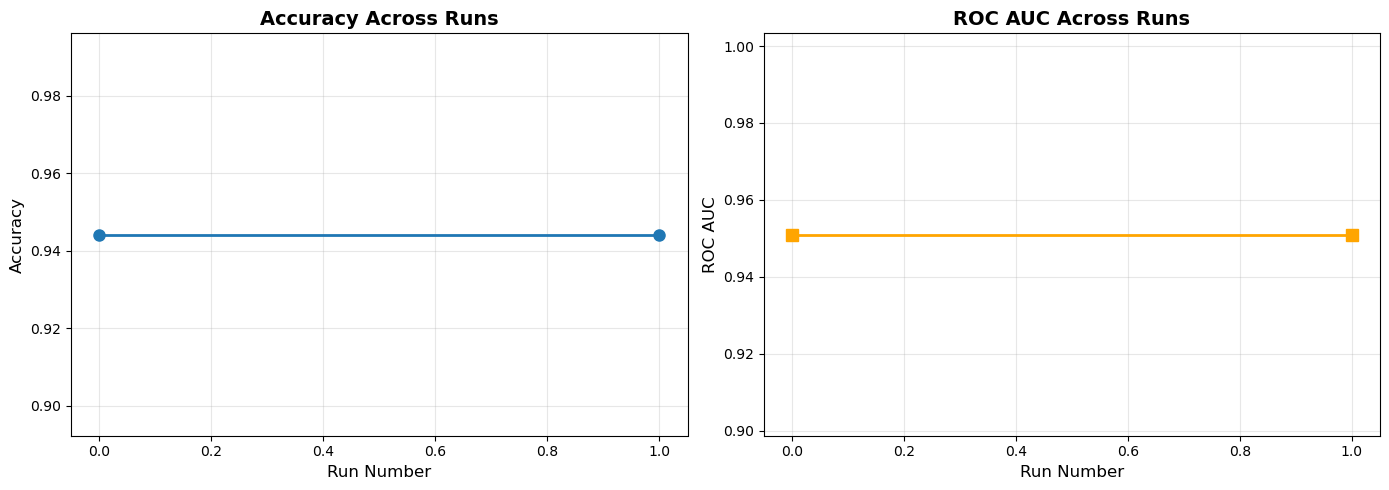


Best Run by ROC AUC:
  Run ID: fc6020f7036e4ec7aae58a2a9f5263f2
  ROC AUC: 0.9510
  Accuracy: 0.9442
  Precision: 0.3827
  Recall: 0.7949


In [63]:
# Cell [7]: Compare Multiple Runs (Run this after training several times)
import matplotlib.pyplot as plt

runs = mlflow.search_runs(experiment_names=[config.experiment.name])

if len(runs) > 1:
    print(f"Comparing {len(runs)} runs...")
    
    # Sort by time
    runs_sorted = runs.sort_values('start_time')
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(range(len(runs_sorted)), runs_sorted['metrics.accuracy'], 
                 marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel('Run Number', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy Across Runs', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # ROC AUC
    axes[1].plot(range(len(runs_sorted)), runs_sorted['metrics.roc_auc'], 
                 marker='s', color='orange', linewidth=2, markersize=8)
    axes[1].set_xlabel('Run Number', fontsize=12)
    axes[1].set_ylabel('ROC AUC', fontsize=12)
    axes[1].set_title('ROC AUC Across Runs', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best run
    print(f"\nBest Run by ROC AUC:")
    best_idx = runs_sorted['metrics.roc_auc'].idxmax()
    best_run = runs_sorted.loc[best_idx]
    print(f"  Run ID: {best_run['run_id']}")
    print(f"  ROC AUC: {best_run['metrics.roc_auc']:.4f}")
    print(f"  Accuracy: {best_run['metrics.accuracy']:.4f}")
    print(f"  Precision: {best_run['metrics.precision']:.4f}")
    print(f"  Recall: {best_run['metrics.recall']:.4f}")
    
elif len(runs) == 1:
    print(f"Only 1 run found. Train more models to compare!")
    print(f"Tip: Change hyperparameters in config.yaml and run Cell [4] again")
else:
    print("No runs found!")

In [45]:
# Cell [8]: View MLflow Artifacts
if len(runs) > 0:
    client = mlflow.tracking.MlflowClient()
    latest_run_id = runs.iloc[0]['run_id']
    
    print(f"Artifacts for Run: {latest_run_id}")
    print("="*60)
    
    artifacts = client.list_artifacts(latest_run_id)
    
    for artifact in artifacts:
        print(f"{artifact.path}")
        if artifact.is_dir:
            # List files in subdirectory
            sub_artifacts = client.list_artifacts(latest_run_id, artifact.path)
            for sub in sub_artifacts:
                print(f"   └─ {sub.path}")
else:
    print("No runs found!")

Artifacts for Run: 5dd253387de84c8bb5be10f0e7389f8b
artifacts
   └─ artifacts/config.yaml
   └─ artifacts/data
   └─ artifacts/experiment_summary.json
   └─ artifacts/metrics
   └─ artifacts/models
   └─ artifacts/plots
   └─ artifacts/predictions
model
   └─ model/MLmodel
   └─ model/conda.yaml
   └─ model/model.pkl
   └─ model/python_env.yaml
   └─ model/requirements.txt


In [46]:
# Cell [9]: Instructions for MLflow UI
print("TO VIEW MLFLOW UI:")
print("="*60)
print("\n1. Open a NEW terminal/command prompt")
print("2. Navigate to project directory:")
print(f"   cd {os.getcwd()}")
print("\n3. Run:")
print("   mlflow ui")
print("\n4. Open browser and go to:")
print("   http://localhost:5000")
print("\n" + "="*60)

TO VIEW MLFLOW UI:

1. Open a NEW terminal/command prompt
2. Navigate to project directory:
   cd C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package

3. Run:
   mlflow ui

4. Open browser and go to:
   http://localhost:5000



In [47]:
import mlflow
mlflow.set_tracking_uri("./mlruns")
runs = mlflow.search_runs(experiment_names=["customer_conversion_baseline"])
print(f"Runs found: {len(runs)}")

Runs found: 2


In [66]:
# ============================================================
# Cell: Run Automated Tests
# ============================================================
import subprocess
import sys

print("Running Automated Data Validation Tests")
print("=" * 80)

# Run pytest (simplified - pytest.ini handles config)
result = subprocess.run(
    [sys.executable, "-m", "pytest"],
    capture_output=True,
    text=True,
    cwd="."  # Run from project root
)

# Show output
print(result.stdout)

# Summary
print("=" * 80)
if result.returncode == 0:
    print("ALL TESTS PASSED!")
else:
    print("SOME TESTS FAILED")
    
print("=" * 80)

Running Automated Data Validation Tests
============================= test session starts =============================
platform win32 -- Python 3.12.7, pytest-8.3.4, pluggy-1.6.0 -- C:\Users\jahna\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\jahna\Downloads\Hubspot_Assesment\Hubspot_Assesment\ml-framework-package
configfile: pytest.ini
testpaths: tests
plugins: anyio-4.2.0, langsmith-0.4.31
collecting ... collected 9 items

tests/test_data_validation.py::TestBusinessLogic::test_alexa_rank_reasonable_values PASSED [ 11%]
tests/test_data_validation.py::TestBusinessLogic::test_actions_must_exceed_users PASSED [ 22%]
tests/test_data_validation.py::TestBusinessLogic::test_usage_data_has_matching_companies PASSED [ 33%]
tests/test_data_validation.py::TestBusinessLogic::test_action_counts_non_negative PASSED [ 44%]
tests/test_data_validation.py::TestPipelineBehavior::test_pipeline_removes_invalid_mrr_customers PASSED [ 55%]
tests/test_data_validation.py::TestPipelineBehavio